In [8]:
import pandas as pd
import numpy as np
from BuildTsModel import plot_forecast, evaluate_forecast, residcheck
import statsmodels.api as sm
import matplotlib.pyplot as plt
# set plot style to ggplot2
plt.style.use('ggplot')
# maximize the size of the labels, ticks, and figures
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# legend settings
plt.rcParams['legend.fontsize'] = 10

In [9]:
# import the training and testing data
train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
train = train.squeeze()
train.index.freq = 'MS'
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)
test = test.squeeze()
test.index.freq = 'MS'

# Linear regression with seasonal dummies

In [10]:
# Encode the seasonal component to dummy variables
seasonal_dummies = pd.get_dummies(train.index.month, prefix='month', drop_first=True)

# Create a time variable that starts at 1 and increases by 1 for each observation
time = np.arange(1, len(train) + 1)

# Create a DataFrame for time, seasonal dummies, and the time series
train_data = pd.DataFrame({'time': time, 'retail_sales': train.values})
train_data = pd.concat([train_data, seasonal_dummies], axis=1)

# Reorder columns to make 'Sales' the last column
cols = [col for col in train_data.columns if col != 'retail_sales'] + ['retail_sales']
train_data = train_data[cols]
train_data = train_data[200:]
train_data.index = train.index[200:]

# Build a linear regression model with the time variable and seasonal dummies
# Add a constant to the model
X = train_data.drop('retail_sales', axis=1)
X = sm.add_constant(X)
y = train_data['retail_sales']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           retail_sales   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     117.4
Date:                Sat, 27 May 2023   Prob (F-statistic):           1.85e-66
Time:                        07:57:59   Log-Likelihood:                -635.70
No. Observations:                 152   AIC:                             1297.
Df Residuals:                     139   BIC:                             1337.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.7612      9.661     20.677      0.0

In [11]:
# evalue the model on the test set
# Encode the seasonal component to dummy variables
seasonal_dummies = pd.get_dummies(test.index.month, prefix='month', drop_first=True)

# Create a time variable that starts after the train set and increases by 1 for each observation
time = np.arange(len(train) + 1, len(train) + len(test) + 1)

# Create a DataFrame for time, seasonal dummies, and the time series
test_data = pd.DataFrame({'time': time, 'retail_sales': test.values})
test_data = pd.concat([test_data, seasonal_dummies], axis=1)
test_data.index = test.index

# Reorder columns to make 'Sales' the last column
cols = [col for col in test_data.columns if col != 'retail_sales'] + ['retail_sales']
test_data = test_data[cols]

# Make predictions for the test set
X = test_data.drop('retail_sales', axis=1)
X = sm.add_constant(X)
y = test_data['retail_sales']
test_data['forecast_mean'] = results.predict(X)

In [12]:
# Evaluate the model on the train set
train_eval = evaluate_forecast('LR_train', train_data['retail_sales'], results.fittedvalues)
print(train_eval)

# Evaluate the model on the test set
test_eval = evaluate_forecast('LR_test', test_data['retail_sales'], test_data['forecast_mean'])
print(test_eval)

{'Model': 'LR_train', 'MAE': 9.526, 'RMSE': 15.8516, 'MAPE': 1.9226}
{'Model': 'LR_test', 'MAE': 35.7256, 'RMSE': 38.8608, 'MAPE': 5.8194}


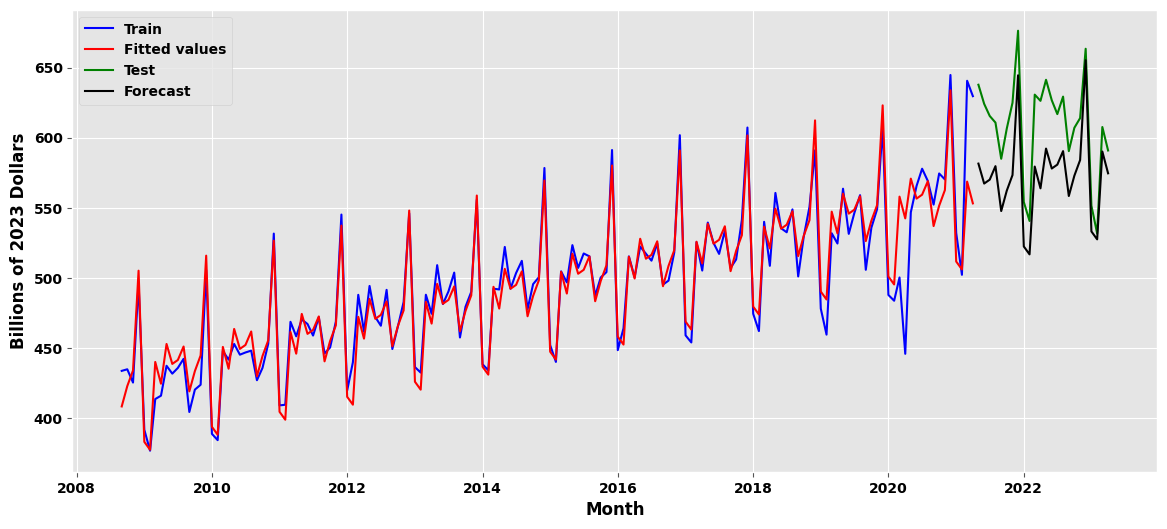

In [13]:
# plot the results
plot_forecast(train_data['retail_sales'], 
              test_data['retail_sales'], 
              results.fittedvalues, 
              test_data,
              'Linear Regression')